<a href="https://colab.research.google.com/github/Alyssl24/MINST/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5372550.96it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 176581.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1487689.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3415909.77it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
from torch.utils.data import DataLoader #permet de parcourir
batch_size_choose=32
train_dataloader = DataLoader(training_data, batch_size=batch_size_choose, shuffle=True) #le shuffle permet de melanger le set de data
test_dataloader = DataLoader(test_data, batch_size=batch_size_choose, shuffle=True)

In [ ]:
#fonction qui verifie si c correct ou nn
def correct(output, target):
    return torch.sum(output == target).item()

In [ ]:
def correct2(output, target):
    # Binarize the output and target to count the correct pixels
    output_bin = torch.round(output)
    target_bin = torch.round(target)
    return torch.sum(output_bin == target_bin).item()

In [ ]:
#boucle qui traite chaques lots de données (data et target sont des listes)
#donc en gros notre BD est separer en lot par le dataloader(qui s"appelle batch)
#puis chaque batch est traite par ses boucles simulatné car c des numpys.
def train(data_loader, model, criterion, optimizer):
    model.train()
    num_batches = len(data_loader)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Do a forward pass

        output,mu,log_var = model(data)

        # Calculate the loss
        target=model.flatt(data)
        loss_kl=-0.5 * torch.sum(1 + log_var - mu.pow(2) - (log_var.exp()))
        loss = criterion(output, target) + loss_kl

        total_loss += loss

        # Count number of correct digits

        total_correct += correct(output,target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print("miaou")
    train_loss = total_loss/num_batches
    accuracy = total_correct/(25088*len(data_loader))  # 25088 = len(ouput)*len(ouput[0])
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

In [ ]:
#version ou j'essaie de recup les couches
from collections import OrderedDict as OrderedDict
#ordered dict c un dico ordonnée mais jrv pas a recup les couches encores
class SimpleMLP(nn.Module):
    def __init__(self):

        super().__init__()
        self.flatt=nn.Flatten()
        self.line1=nn.Linear(28*28, 256)
        self.relu=nn.ReLU()
        self.line2=nn.Linear(256,64)
        self.log_var=nn.Linear(64,2)
        self.mu=nn.Linear(64,2)
        self.line6=nn.Linear(2,64)
        self.line3=nn.Linear(64,256)
        self.line4=nn.Linear(256, 28*28)
        self.dim2=0;
        self.sig=nn.Sigmoid()
#tsne
    def encoder(self,x):
        x=self.flatt(x)
        x=self.line1(x)
        x=self.relu(x)
        x=self.line2(x)
        x=self.relu(x)
        return x

    def decoder(self,x):
        x=self.line6(x)
        x=self.relu(x)
        x=self.line3(x)
        x=self.relu(x)
        x=self.line4(x)
        x=self.sig(x)
        return x

    def  reparameterize ( self, mu, log_var ):
        # Calculer l'écart type par rapport à la variance log
        std = torch.exp( 0.5 * log_var)
        # randnlike fais une loi normale centrée réduite !!
        #std en parametre c pour la taille
        eps = torch.randn_like(std)
        #loi normale formule
        return mu+eps*std

    def forward(self, x):
       #x=nn.functional.normalize(x)
        x=self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        z=self.decoder(z)
        return z,mu,log_var

In [ ]:
#CREATION DE NOTRE MODELE
model = SimpleMLP()
print(model)

SimpleMLP(
  (flatt): Flatten(start_dim=1, end_dim=-1)
  (line1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (line2): Linear(in_features=256, out_features=64, bias=True)
  (log_var): Linear(in_features=64, out_features=2, bias=True)
  (mu): Linear(in_features=64, out_features=2, bias=True)
  (line6): Linear(in_features=2, out_features=64, bias=True)
  (line3): Linear(in_features=64, out_features=256, bias=True)
  (line4): Linear(in_features=256, out_features=784, bias=True)
  (sig): Sigmoid()
)


In [ ]:
criterion = nn.MSELoss(reduction='sum')    #pour l'instant on a choisit celle al est on a des bon resultat
optimizer = torch.optim.Adam(model.parameters()) #on choisit lesquelles ?

In [ ]:
epochs = 10
for epoch in range(epochs):
   print(f"Epoch: {epoch+1} ...")
   train(train_dataloader, model, criterion, optimizer)

Epoch: 1 ...
miaou
Average loss: 1128.452393, accuracy: 0.00%
Epoch: 2 ...
miaou
Average loss: 1123.585327, accuracy: 0.00%
Epoch: 3 ...
miaou
Average loss: 1121.277222, accuracy: 0.00%
Epoch: 4 ...


KeyboardInterrupt: 

In [ ]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            target=model.flatt(data)
            # Do a forward pass
            output,mu,log_var = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            loss_kl=-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = criterion(output, target) + loss_kl

            test_loss += loss

        # Count number of correct digits

        total_correct += correct(output,target)
        test_loss += loss.item()

            # Count number of correct digits
        total_correct += correct(output, target)

    train_loss = test_loss/(num_batches*28*28)
    accuracy = total_correct/(num_items*28*28)

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [ ]:
test(test_dataloader, model, criterion)

Testset accuracy: 0.0%, average loss: 353895.781250


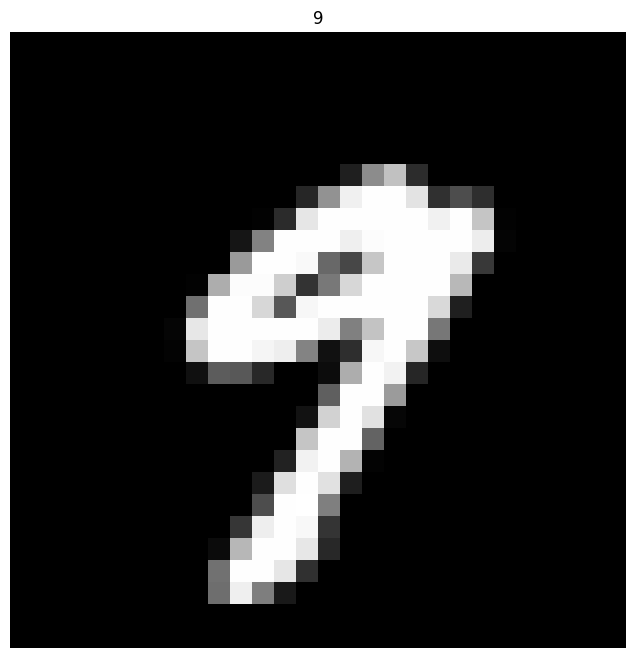

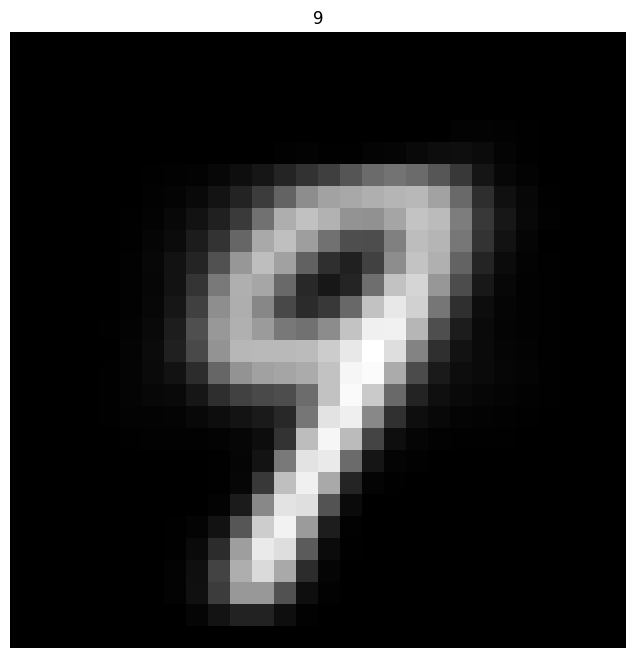

In [ ]:
imageNum=20

figure = plt.figure(figsize=(8, 8))
cols, rows = 1,1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #genere un index aleatoire
    img, label = test_data[imageNum] #renvoie image + label (c que limage)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #affiche l'image
plt.show()


figure = plt.figure(figsize=(8, 8))
cols, rows = 1,1
predis=np.array(model(test_data[imageNum][0])[0].tolist()).reshape(28,28)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() #genere un index aleatoire
    img, label = (predis,label) #renvoie image + label (c que limage)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") #affiche l'image
plt.show()